In [25]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy


# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [26]:
# Base directory containing class folders
data_dir = './Data'
train_img_list, train_label_list = [], []
test_img_list, test_label_list = [], []
val_img_list, val_label_list = [], []

# Set random seed for reproducibility
random.seed(42)

# Loop through each class folder
for label in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label)
    
    # Ensure it's a directory (skip any non-directory files)
    if os.path.isdir(label_path):
        images = os.listdir(label_path)
        random.shuffle(images)
        
        # Calculate split indices
        train_split = int(0.8 * len(images))
        test_split = int(0.9 * len(images))
        
        # Split the images
        train_images = images[:train_split]
        test_images = images[train_split:test_split]
        val_images = images[test_split:]
        
        # Append paths and labels to respective lists
        for img in train_images:
            train_img_list.append(os.path.join(label_path, img))
            train_label_list.append(label)
        
        for img in test_images:
            test_img_list.append(os.path.join(label_path, img))
            test_label_list.append(label)
        
        for img in val_images:
            val_img_list.append(os.path.join(label_path, img))
            val_label_list.append(label)

# Display the count of images in each split
print(f"Total training images: {len(train_img_list)}")
print(f"Total testing images: {len(test_img_list)}")
print(f"Total validation images: {len(val_img_list)}")

Total training images: 2475
Total testing images: 309
Total validation images: 312


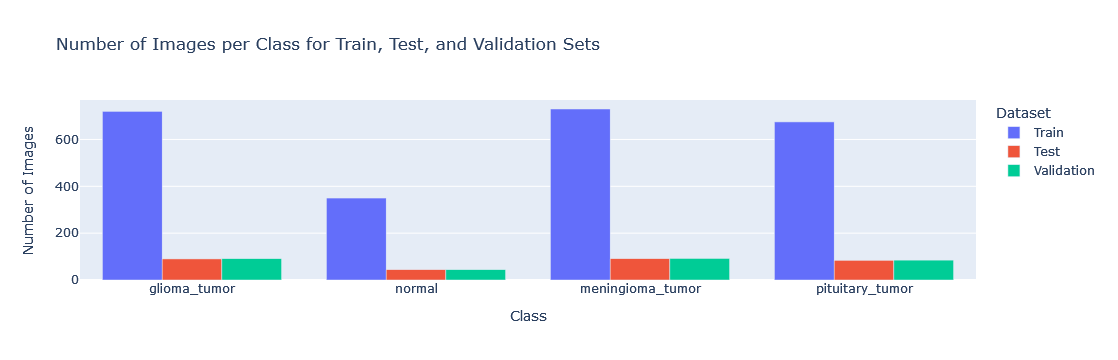

In [27]:
# Count images in each class for each split
train_counts = {label: train_label_list.count(label) for label in set(train_label_list)}
test_counts = {label: test_label_list.count(label) for label in set(test_label_list)}
val_counts = {label: val_label_list.count(label) for label in set(val_label_list)}

# Combine counts into a DataFrame
df_counts = pd.DataFrame({
    'Class': list(train_counts.keys()),
    'Train': list(train_counts.values()),
    'Test': [test_counts[label] for label in train_counts.keys()],
    'Validation': [val_counts[label] for label in train_counts.keys()]
})

# Melt DataFrame for grouped plotting
df_melted = df_counts.melt(id_vars="Class", var_name="Dataset", value_name="Count")

# Create grouped bar plot with Plotly
fig = px.bar(df_melted, x='Class', y='Count', color='Dataset',
             barmode='group',  # Group bars by 'Dataset'
             title="Number of Images per Class for Train, Test, and Validation Sets",
             labels={'Count': 'Number of Images', 'Class': 'Class'},
             hover_data={'Count': True})

fig.update_layout(xaxis_title="Class", yaxis_title="Number of Images")

fig.show()

Found 2479 images belonging to 4 classes.
Found 617 images belonging to 4 classes.
Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 49s 591ms/step - accuracy: 0.3369 - loss: 3.9966 - val_accuracy: 0.2917 - val_loss: 5.9457 - learning_rate: 0.0010
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 50s 636ms/step - accuracy: 0.3833 - loss: 1.9903 - val_accuracy: 0.2723 - val_loss: 36.1561 - learning_rate: 0.0010
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 42s 539ms/step - accuracy: 0.3543 - loss: 1.5567 - val_accuracy: 0.2755 - val_loss: 31.9612 - learning_rate: 0.0010
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 43s 548ms/step - accuracy: 0.4561 - loss: 1.3919 - val_accuracy: 0.3566 - val_loss: 4.8924 - learning_rate: 0.0010
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 42s 535ms/step - accuracy: 0.4557 - loss: 1.2507 - val_accuracy: 0.3355 - val_loss: 6.6161 - learning_rate: 0.0010
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 44s 568ms/step - accuracy: 0.4388 - loss: 1.2398 - val_accuracy: 0.2917 - val_loss: 13.2368 - learning_rate: 0.0

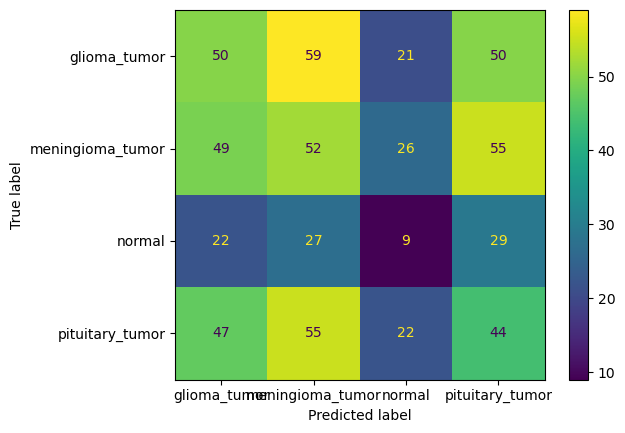

In [32]:
# Data Augmentation and Generators with validation_split
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.15, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest",
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(data_dir, target_size=(150, 150), batch_size=32,
                                                    class_mode='categorical', subset='training')

validation_generator = train_datagen.flow_from_directory(data_dir, target_size=(150, 150), batch_size=32,
                                                         class_mode='categorical', subset='validation')

# Model Definition
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True)

# Train the Model
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[early_stopping, reduce_lr, checkpoint])

# Evaluate Model - use validation_generator as the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

# Display Confusion Matrix
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys()).plot()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


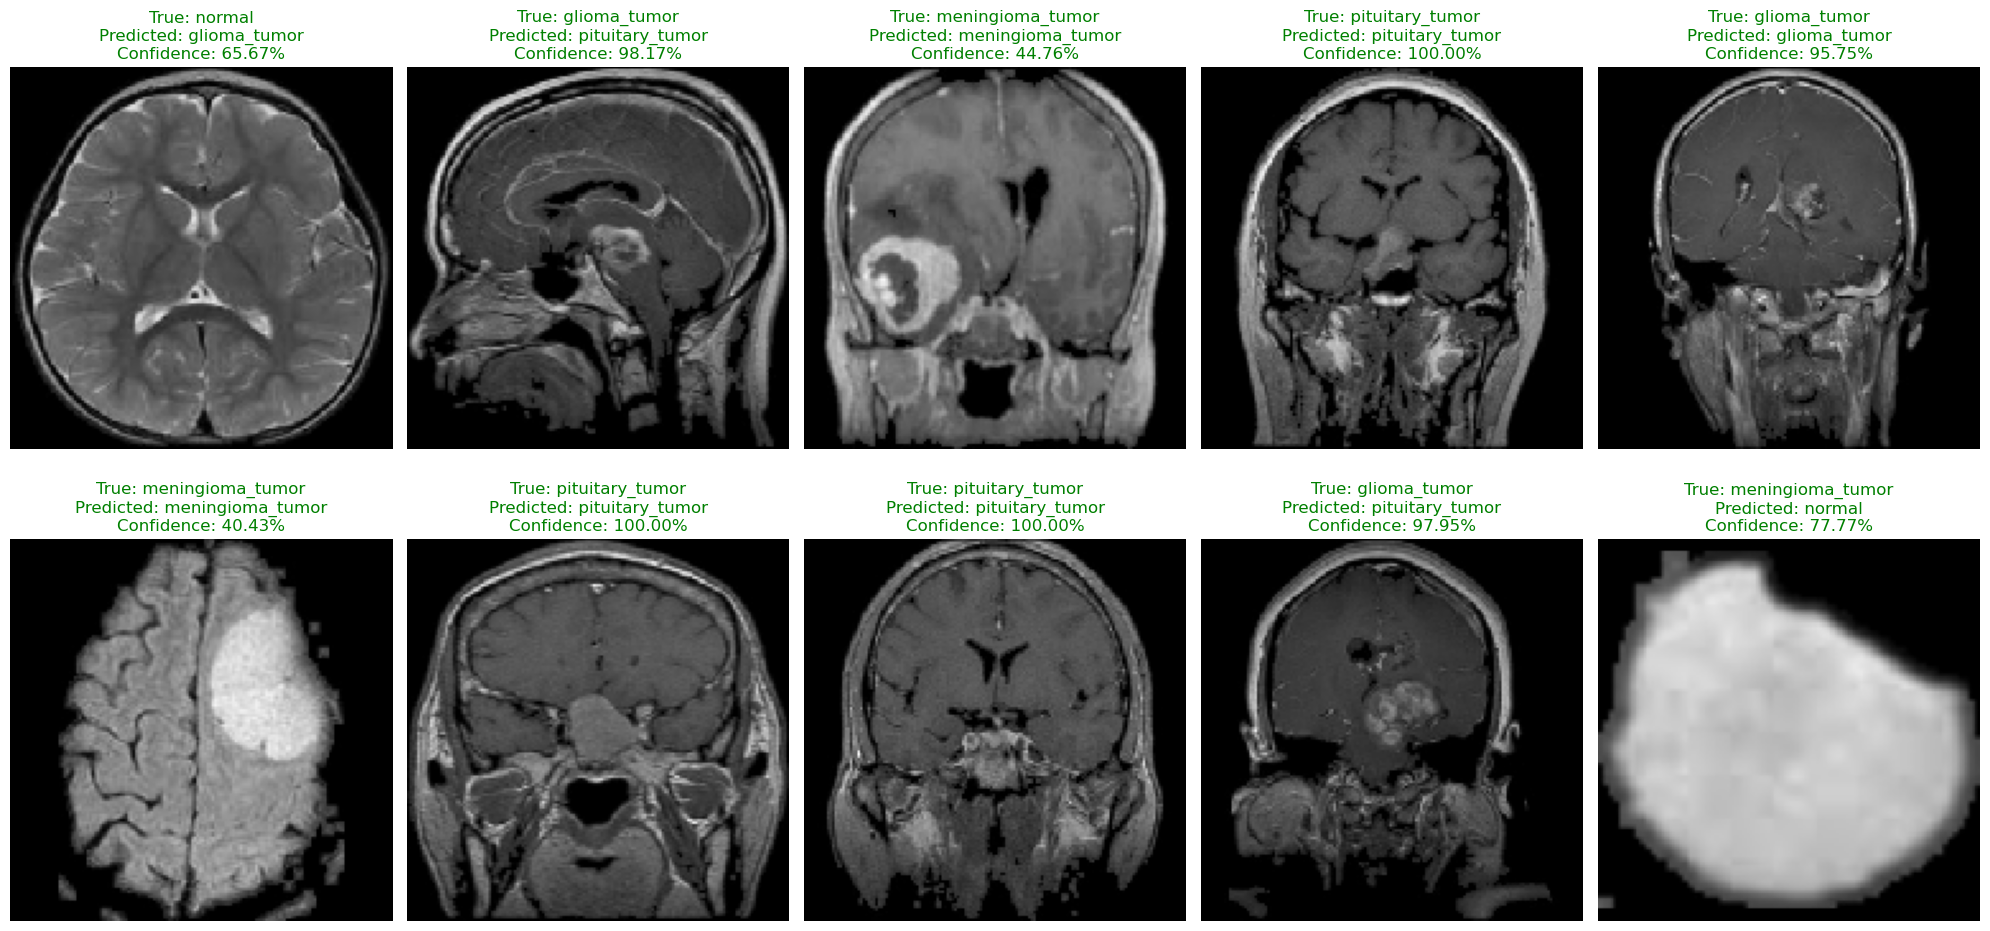

In [33]:
def display_predictions(generator, model, num_images=10):
    # Set up figure for display
    plt.figure(figsize=(20, 10))
    
    # Get a random sample of images from the generator
    for i in range(num_images):
        # Randomly pick an image index from the generator
        index = random.randint(0, generator.samples - 1)
        
        # Load the image and preprocess it
        img_path = generator.filepaths[index]
        img = load_img(img_path, target_size=(150, 150))
        img_array = img_to_array(img) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make prediction
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction) * 100
        
        # Get true label
        true_class = generator.labels[index]
        class_labels = list(generator.class_indices.keys())
        
        # Plot the image
        plt.subplot(num_images // 5, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        
        # Add title with true label, predicted label, and confidence
        plt.title(f"True: {class_labels[true_class]}\n"
                  f"Predicted: {class_labels[predicted_class]}\n"
                  f"Confidence: {confidence:.2f}%", color="green")

    plt.tight_layout()
    plt.show()

# Call the function
display_predictions(validation_generator, model, num_images=10)